# Five Days Plan

## Import Packages 

In [22]:
using ForwardDiff
using HCubature
using StaticArrays 
using LinearAlgebra 
using BenchmarkTools
using Test 
using Plots

const Point2D = SVector{2,Float64};

In [27]:
const myPoint2D = SVector{2,Real}; # more generic to allow for dual numbders to be created by ForwardDiff 

## Section 1: Introduction - Goals 

<b>Goals:</b>
1. introduce Julia as instrument to solve problems of TNO The Hague. Matlab to be phased out. TNO further stranger for students;  
2. reduce wall clock time for assembly by replacing an interpreted double loop over all elements in the mesh (destination and source triangles) by a compiled version;
3. parallel shared memory assembly;
4. reduce the singularity of the seft-term using first integrate, then differentiate;

<b>Some theory:</b>

Double integral over a prismatic element $K$ of thickness $d$ by mapping onto the reference element $\widehat{k}$. More. 

<b>Links</b>
1. [TaylorSeries.jl](https://juliadiff.org/TaylorSeries.jl/stable/)
2. [Inti.jl](https://github.com/IntegralEquations/Inti.jl) and their [handling singular integrals](https://github.com/IntegralEquations/Inti.jl/issues/131)
3. [discourse post by StevenG](https://discourse.julialang.org/t/avoiding-allocations-when-normalizing-a-vector/113913/6) on using HCubature with Static Arrays; 
4. [discourse post by StevenG](https://discourse.julialang.org/t/2d-integration-over-non-rectangular-domain-using-cubature/2991/11): integration over triangles by a coordinate transformation and avoiding the use of iterated integrals that do not take full advantage of adaptivity in two spatial dimensions. Let $\hat{T}$ denote the reference triangle as integration domain . Then

$$
\int_{\hat{T}} f(x,y) dx dy = \int_0^1 \int_0^x f(x,y) dy dx 
$$

in an iterated integral in which $x$ is constant for integration over $y$. Using the coordinate transformation $y = u x$ (and thus $u=1$ in  case that $y=x$ in the upper bound) and thus $dy = x du$, we arrive at 

$$
\int_{\hat{T}} f(x,y) dx dy = \int_0^1 \int_0^1 f(x,ux)*x du dx \,   
$$

where the Jacobian $u$ multiplies $f(x,u*x)$. In this formulation, HCubature can be used. 

## Section 2: Tentative Five-Day Plan 

### Day 1: Interview - Refine Plan Below 

1. details function for first (inner) integral;
3. agree on test data (location where to evaluate functiob) and test results for function for inner integral;
4. agree on quadrature rules for prisms. Current product of quadrature on triangle and interval is used. No information of logarithmic singularity on the edges of the prism is exploited; 
5. details assembly matrix and vector for reference element. Agree on test data and test reference results;
6. details assembly matrix and vector for physical element. Agree on test data and test reference results;
7. details triangular meshes to be used for assembly. Pass Matlab meshes to Julia? Agree on test data and test reference results;
8. details assembly matrix and vector for entire mesh. Agree on test data and test reference results;
9. overall pseudo-code of entire code; 

### Day 2: Function for Analytical Expression of First (Inner) Integral 

1. integrate adaptively over reference element once. Freeze and re-use quad points and weights; 

Include testing. 

### Day 3: Matrix and Vector of Single Triangular Element 

Include testing. 

### Day 4: Matrix and Vector Assembly - Linear Solve - Post-Processing 

Include testing. 

### Day 5: Buffer 

##  Section 3: Using 2D Static Arrays to Represent 2D Points and Lines  

In [2]:
# representation of points 
r1 = Point2D(0.,0.)
r2 = Point2D(1.,0.)
r3 = Point2D(0.,1.)
norm(r1-r2)

1.0

In [3]:
# representation of lines 
line_r21(t) = r1 + t*(r2-r1) 
@test line_r21(0) == r1
@test line_r21(1) == r2

Test Passed

##  Section 4: Using HCubature 

### Section 1.4: Scalar Argument

In [4]:
# function in one argument 
function integrand(x) return x.*x end 

hcubature(x -> integrand(x), (0,), (1,))

([0.3333333333333333], 5.551115123125783e-17)

In [5]:
# function is one argument and additional parameter 
function integrand(x,p) return p*x.*x end
p = 5.
hcubature(x -> integrand(x,p), (0,), (1,))

([1.6666666666666665], 0.0)

### Section 2.4: 2-Vector Argument

In [6]:
# integrand with 2-vector as input
function integrand2(x) return  x[1]*x[1]+x[2]*x[2] end 

hcubature(x -> integrand2(x), (0,0), (1,1))

# integrand with 2-static-vector as input
function integrand3(x) return  x.x*x.x+x.y*x.y end

hcubature(x -> integrand3(Point2D(x[1],x[2])), (0,0), (1,1))

(0.6666666666666665, 2.220446049250313e-16)

In [7]:
# rd: location of destination point 
# rs: location of source point
integrand3(rd, rs) = normalize(rd - rs) 
foo(rd) = hcubature(rs->integrand3(rd, Point2D(rs[1],rs[2])), (0,0), (1,1))[1]
foo(Point2D(.5,.5))

2-element SVector{2, Float64} with indices SOneTo(2):
 0.0
 8.543973614545323e-18

### Section 3.4: Two-Level Nested Calls of HCubature  

In [8]:
# here we assume a reference triangle 
# rd: location of destination point 
# rs: location of source point
integrand_inner(rd, rs) = 1/norm(rd - rs) 
integrand_outer(rd) = hcubature(t->integrand_inner(rd, Point2D(0,t[1])), (0,), (1,))[1]
integrand_value     = hcubature(rd->integrand_outer(Point2D(rd[1],rd[2]*rd[1])*rd[1]), (0,0), (1,1))[1]

3.0398499842418647

## Section 5: Using Automatic Differentiation in ForwardDiff 

### Section 1.5: Differentiation of Integral wrt a Parameter 

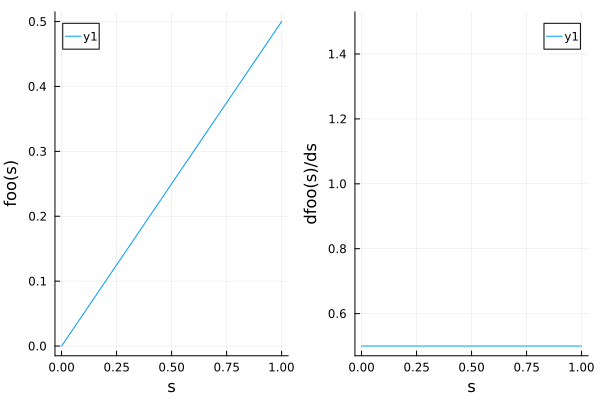

In [9]:
# gnu(s,t) is a function in two variables
gnu(s,t) = s*t
# foo(s) is obtained from gnu(s,t) by integrating in t 
foo(s)  = hcubature(t -> gnu(s,t), (0,), (1,))[1]
# dfoo(s) = d/ds[ foo(s) ]
dfoo(s) = ForwardDiff.derivative(s->foo(s), s) 

# evaluation 
svec = 0:0.1:1
foovec  = [foo(s).x  for s in svec]
dfoovec = [dfoo(s).x for s in svec]

# post-processing 
p1 = plot(svec, foovec,  xlabel="s", ylabel="foo(s)")
p2 = plot(svec, dfoovec, xlabel="s", ylabel="dfoo(s)/ds")
plot(p1,p2,layout=(1,2))

### Section 2.5: ForwardDiff and StaticVectors 

Requires Dual numbers for StaticVectoirs. These are provided by [PreallocationTools.jl](https://github.com/SciML/PreallocationTools.jl). See also, this [Discourse post](https://discourse.julialang.org/t/solving-nonlinear-equations-using-dual-numbers/126967/8). See also [this manual page](https://juliarobotics.org/RigidBodyDynamics.jl/v2.1/generated/5.%20Derivatives%20and%20gradients%20using%20ForwardDiff/5.%20Derivatives%20and%20gradients%20using%20ForwardDiff/).  

In [52]:
function foo(x)
    val = zero(eltype(x))
    val = x[1]+x[2]
    return val
end 

foo (generic function with 1 method)

In [53]:
r1 = myPoint2D(1.,0.)
r2 = [2., 0.]
display(foo(r1))
display(foo(r2))

1.0

2.0

In [54]:
dfoo(x) = ForwardDiff.derivative(x->foo(myPoint2D(x,0.)), x) 

dfoo (generic function with 1 method)

In [55]:
dfoo(1.)

1.0

In [56]:
dfoo(x) = ForwardDiff.gradient(x->foo(x), x)

dfoo (generic function with 1 method)

In [57]:
display(typeof(r1))
dfoo(r1)

SVector{2, Real} (alias for SArray{Tuple{2}, Real, 1, 2})

2-element SVector{2, Float64} with indices SOneTo(2):
 1.0
 1.0

## Section 6: Eugene's 2D Triangle

<b>Preliminaries</b> Given triangle $K$ with nodes 
$$
\mathbf{r}_1 = (0,0)   \hspace{.3cm} 
\mathbf{r}_2 = (1,0)   \hspace{.3cm}
\mathbf{r}_3 = (0,y_3) \text{ with } 0 \leq y_3 \leq 1
$$

For $\mathbf{r} = (x,y)$ in or outside triangle $K$ (check with Morandi)
$$
Q(\mathbf{r}) = \log \frac{\|\mathbf{r} - \mathbf{r}_2\|+\|\mathbf{r} - \mathbf{r}_1\|+\|\mathbf{r}_2 - \mathbf{r}_1\|}
                          {\|\mathbf{r} - \mathbf{r}_2\|+\|\mathbf{r} - \mathbf{r}_1\|-\|\mathbf{r}_2 - \mathbf{r}_1\|}
$$
The function $Q(\mathbf{r})$ has a logarithmic singularty on the edge connecting $\mathbf{r}_1$ and $\mathbf{r}_2$, i.e., for $\mathbf{r}$ on the edge from  $\mathbf{r}_1$ and $\mathbf{r}_2$, the denominator of $Q(\mathbf{r})$ is zero. 

<b>Inner Integral</b> We define an inner integral with domain of integration the edge from $\mathbf{r}_1$ to $\mathbf{r}_2$. Let the source point location $\mathbf{r}'$ denote a point on this edge. Then $\mathbf{r}' = (x',0)$ and 

$$
\| \mathbf{r} - \mathbf{r}' \| = \sqrt{x^2+(y-y')^2} \, . 
$$

The function $f(\mathbf{r})$ performs integration over all source points over the edge $\mathbf{r}_1$ - $\mathbf{r}_2$ (where $x'$ is fixed to $x'=0$)
$$
f(\mathbf{r}) = \int_0^{y_2} \frac{1}{\sqrt{x^2+(x-y')^2}}\, dy' = \log Q(\mathbf{r})
$$

Does hcubature allow to compute this integra? Can result be compared with analytical approximation?  

<b>Outer Integral</b> We define an outer integral $I$ with domain of integration the triangle $K$ 

$$
I = \int_{K} f(\mathbf{r}) \, d\mathbf{r} \, . 
$$

In [10]:
integrand_inner(rd, rs) = 1/norm(rd - rs) 
integrand_outer(rd) = hcubature(t->integrand_inner(rd, Point2D(0,t[1])), (0,), (1,))[1]
integrand_value     = hcubature(rd->integrand_outer(Point2D(rd[1],rd[2]*rd[1])*rd[1]), (0,0), (1,1))[1]

3.0398499842418647

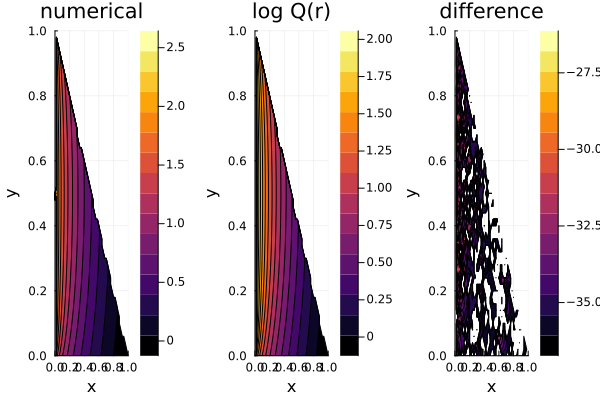

In [20]:
r1 = Point2D(0.,0.)
r2 = Point2D(0.,1.)

N = 50; Np1 = N+1
xvec = Vector(0:1/N:1)
yvec = Vector(0:1/N:1) 
values     = zeros(Np1, Np1)
valueslogQ = zeros(Np1, Np1)

for (i, xi) in enumerate(xvec)
    for (j, yj) in enumerate(yvec)
        rd = Point2D(xi,yj)
        numer = norm(rd-r2) + norm(rd-r1) + norm(r2-r1)  
        denom = norm(rd-r2) + norm(rd-r1) - norm(r2-r1)
        if (yj<=1-xi) 
            values[i,j]     = integrand_outer(rd) 
            valueslogQ[i,j] = log(numer/denom)
        end 
    end
end 

p1 = contourf(xvec, yvec, log.(values'),  xlabel="x", ylabel="y", title = "numerical") 
p2 = contourf(xvec, yvec, log.(valueslogQ'),  xlabel="x", ylabel="y", title = "log Q(r)") 
p3 = contourf(xvec, yvec, log.(abs.(valueslogQ'-values')),  xlabel="x", ylabel="y", title = "difference")
plot(p1,p2,p3,layout=(1,3)) 

## Section 7: Eugene's 3D Prismatic Element  

Here we extend previous results to more relevant setting. 

Assume $K$ to denote a prismatic element (3D) in the mesh. Assume $\mathbf{r} = (x,y,z)$ to be given. Assume $I_{in}(\mathbf{r}, \mathbf{r}')$ to denote the inner integrand. We wish to compute evalute the outer integrand  

$$
I_{out}(\mathbf{r}) = \int_K I_{in}(\mathbf{r}, \mathbf{r}') d\mathbf{r}' 
$$

using both [HCubature.jl](https://github.com/JuliaMath/HCubature.jl) and [FastTanhSinhQuadrature.jl](https://github.com/svretina/FastTanhSinhQuadrature.jl) and compare results. 